In [2]:
import pandas as pd
import requests
import json

import matplotlib.pyplot as plt
import numpy as np

# Getting timing data from flower
This notebook shows how to get tasks timing data from flower. For this instance 6 nodes x 20 workers are running. flower is at 5555 and by default only stores ~10000 tasks. But it is plenty for this exercise.

In [3]:
def get_result_df():
    result = requests.get('http://localhost:5555/api/tasks')
    data_json = json.loads(result.content)
    return pd.DataFrame.from_dict(data_json, orient='index')

In [4]:
result = requests.get('http://localhost:5555/api/tasks')

In [5]:
data_json = json.loads(result.content)

In [8]:
len(data_json.keys())

10066

In [ ]:
df = pd.DataFrame.from_dict(data_json, orient='index')

Filter for done peeling tasks and then sort by time.

In [33]:
peeling_done_df = df[(df['state'] == 'SUCCESS') & (df['name'] == 'orca.proj.boilerplate.peel')].sort_values(by='timestamp')

# Peeling task graphs

Note that this is for 20 workers per node.

In [31]:
peeling_done_df.columns

Index(['uuid', 'name', 'state', 'received', 'sent', 'started', 'rejected',
       'succeeded', 'failed', 'retried', 'revoked', 'args', 'kwargs', 'eta',
       'expires', 'retries', 'result', 'exception', 'timestamp', 'runtime',
       'traceback', 'exchange', 'routing_key', 'clock', 'client', 'root',
       'root_id', 'parent', 'parent_id', 'children'],
      dtype='object')

The histogram for individual peeling tasks seems to be quite a bit slower than when they are run individually.

Text(0.5, 0, 'runtime in s')

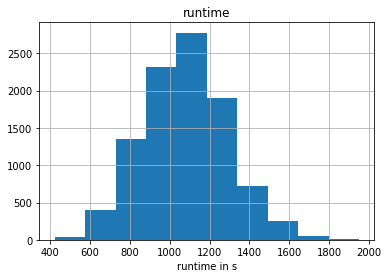

In [30]:
axes =peeling_done_df.hist(column='runtime')
axes[0][0].set_xlabel('runtime in s')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0f2be1dcf8>]],
      dtype=object)

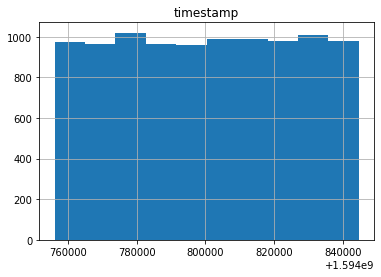

In [32]:
# Just sanity checking to make sure that the finish times are all from relatively recently
peeling_done_df.hist(column='timestamp')

# Throughput
An important metric is the averaged time between tasks finishing in the entire cluster. This gives us a sense of the throughput of the system.

In [49]:
succeeded_times = peeling_done_df['succeeded'].to_numpy()

In [50]:
delta_t = succeeded_times[1:] - succeeded_times[:-1]

In [9]:
def get_delta_t(succeeded_df):
    times = succeeded_df['succeeded'].to_numpy()
    return times[1:] - times[:-1]

Calculate some statistics

In [55]:
delta_t.mean()

9.018259141412154

In [63]:
np.median(delta_t)

6.182690143585205

In [65]:
delta_t.max()

99.67064762115479

In [70]:
delta_t.std()

9.57923043139452

Text(0.5, 0, 'Time between tasks finishing (s)')

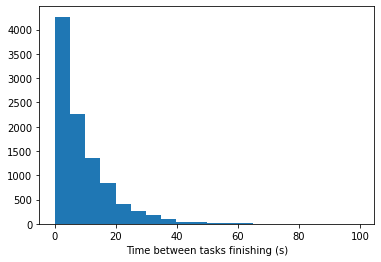

In [69]:
plt.hist(delta_t, bins=20);
plt.xlabel('Time between tasks finishing (s)')

(0.0, 20.0)

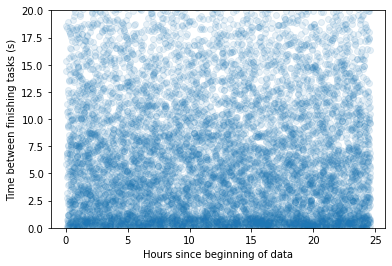

In [81]:
# Now just for a fun scatter plot.
plt.scatter((succeeded_times[1:] - succeeded_times[1])/3600, delta_t, alpha=0.1)
plt.xlabel('Hours since beginning of data')
plt.ylabel('Time between finishing tasks (s)')
plt.ylim([0,20])

# Repeat with concurrency 10 and -Ofair
07/06/2020 9:22AM

I switched workers to use the "-Ofair" option which means that the worker supervisor process will assign tasks that it reserved based on worker availability, rather than just Round Robin. I expect it to have fairly minimal impact on the peeling work.

Now I'm just getting performance data for the past ~12 hours to see how peeling performs with concurrency 10 per node.

In [5]:
df = get_result_df()

In [6]:
peeling_done_recent_df = df[(df['state'] == 'SUCCESS')
                            & (df['name'] == 'orca.proj.boilerplate.peel')
                           & (df['timestamp'] > 1594916807 - 12*3600) ].sort_values(by='timestamp')

In [7]:
peeling_done_recent_df

,uuid,name,state,received,sent,started,rejected,succeeded,failed,retried,...,traceback,exchange,routing_key,clock,client,root,root_id,parent,parent_id,children
c9116866-2cf0-48bc-ba86-385affcaab3f,c9116866-2cf0-48bc-ba86-385affcaab3f,orca.proj.boilerplate.peel,SUCCESS,1.594873e+09,None,1.594873e+09,None,1.594874e+09,None,None,...,None,None,None,9361802,None,347b547e-2459-47b1-8641-9a872047ad3f,347b547e-2459-47b1-8641-9a872047ad3f,0c7119f1-fcbe-4b75-818e-f4022d30bf99,0c7119f1-fcbe-4b75-818e-f4022d30bf99,[]
ff61dcfb-aeea-433d-a787-d3907887a84f,ff61dcfb-aeea-433d-a787-d3907887a84f,orca.proj.boilerplate.peel,SUCCESS,1.594873e+09,None,1.594873e+09,None,1.594874e+09,None,None,...,None,None,None,9361909,None,9899ca98-35a5-45bd-9e62-62e7ffdd9f25,9899ca98-35a5-45bd-9e62-62e7ffdd9f25,30aa7e4c-ed0f-4436-b3b9-6221a6e87aa2,30aa7e4c-ed0f-4436-b3b9-6221a6e87aa2,[]
d66f18ab-8859-4011-9074-d235a707aa66,d66f18ab-8859-4011-9074-d235a707aa66,orca.proj.boilerplate.peel,SUCCESS,1.594873e+09,None,1.594873e+09,None,1.594874e+09,None,None,...,None,None,None,9361910,None,b290572c-64be-450f-8487-1747795dec2a,b290572c-64be-450f-8487-1747795dec2a,a9292c69-1292-4a84-8e45-0f5101331efe,a9292c69-1292-4a84-8e45-0f5101331efe,[]
c2178df7-e476-4f35-9a35-f4bff3eee74b,c2178df7-e476-4f35-9a35-f4bff3eee74b,orca.proj.boilerplate.peel,SUCCESS,1.594873e+09,None,1.594873e+09,None,1.594874e+09,None,None,...,None,None,None,9361964,None,a79d9bb1-944c-4edd-bd47-a41de588fa8b,a79d9bb1-944c-4edd-bd47-a41de588fa8b,b2a853c2-5f70-4161-9d2d-fb1097e91f33,b2a853c2-5f70-4161-9d2d-fb1097e91f33,[]
3c69e241-703f-440e-96b9-f4f9e8efe807,3c69e241-703f-440e-96b9-f4f9e8efe807,orca.proj.boilerplate.peel,SUCCESS,1.594873e+09,None,1.594873e+09,None,1.594874e+09,None,None,...,None,None,None,9361973,None,eb552119-8f84-4471-a7e6-9bc4cbc9f07b,eb552119-8f84-4471-a7e6-9bc4cbc9f07b,85e25880-a7b5-4ce5-ac9f-bd89b9672fb0,85e25880-a7b5-4ce5-ac9f-bd89b9672fb0,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27a1f8aa-8172-4295-b16d-f68350b63e9d,27a1f8aa-8172-4295-b16d-f68350b63e9d,orca.proj.boilerplate.peel,SUCCESS,1.594916e+09,None,1.594916e+09,None,1.594917e+09,None,None,...,None,None,None,9564806,None,0bb66f9c-132b-4633-8053-803f5b5cf468,0bb66f9c-132b-4633-8053-803f5b5cf468,497a94ee-804a-4d03-be85-be18cbc37b2b,497a94ee-804a-4d03-be85-be18cbc37b2b,[]
71cee9c4-8a28-4771-b0f2-2f9a567130db,71cee9c4-8a28-4771-b0f2-2f9a567130db,orca.proj.boilerplate.peel,SUCCESS,1.594916e+09,None,1.594916e+09,None,1.594917e+09,None,None,...,None,None,None,9564860,None,d399f9c5-7bad-43f8-9c72-f53f4f2cb4a9,d399f9c5-7bad-43f8-9c72-f53f4f2cb4a9,5b49a0ed-e21d-4b90-85e6-f2030ea25065,5b49a0ed-e21d-4b90-85e6-f2030ea25065,[]
03941d56-ef1a-4a50-9cbc-393e204ee032,03941d56-ef1a-4a50-9cbc-393e204ee032,orca.proj.boilerplate.peel,SUCCESS,1.594916e+09,None,1.594916e+09,None,1.594917e+09,None,None,...,None,None,None,9564897,None,70626936-cf5a-4944-90a5-0114051f472f,70626936-cf5a-4944-90a5-0114051f472f,0428ec42-ccd9-4d9d-ae29-acbfa19e1276,0428ec42-ccd9-4d9d-ae29-acbfa19e1276,[]
5d85e9c1-bce0-4317-89f2-07a849ae8590,5d85e9c1-bce0-4317-89f2-07a849ae8590,orca.proj.boilerplate.peel,SUCCESS,1.594916e+09,None,1.594916e+09,None,1.594917e+09,None,None,...,None,None,None,9564955,None,946314cf-2ae0-4443-858d-41cdff27f31e,946314cf-2ae0-4443-858d-41cdff27f31e,73dda2cb-3fe6-405b-a490-f192220da03a,73dda2cb-3fe6-405b-a490-f192220da03a,[]


Text(0.5, 0, 'runtime in s')

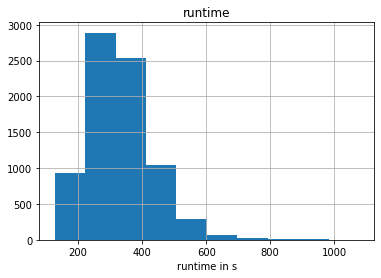

In [8]:
axes =peeling_done_recent_df.hist(column='runtime')
axes[0][0].set_xlabel('runtime in s')

Text(0.5, 0, 'Time between tasks finishing (s)')

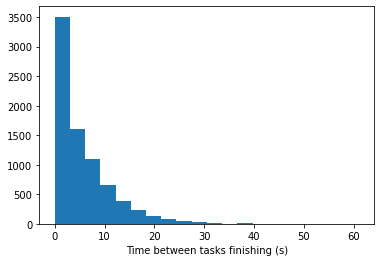

In [11]:
delta_t_concurrency_10 = get_delta_t(peeling_done_recent_df)
plt.hist(delta_t_concurrency_10, bins=20);
plt.xlabel('Time between tasks finishing (s)')

In [12]:
np.mean(delta_t_concurrency_10)

5.5310351770006125

In [14]:
np.median(delta_t_concurrency_10)

3.7056485414505005

In [15]:
np.std(delta_t_concurrency_10)

5.833546332053835